# Quickstart

## Preliminaries

### Imports

In [1]:
import mercs
import numpy as np
from mercs.tests import load_iris, default_dataset
from mercs.core import Mercs

import pandas as pd

# Fit

Here a small MERCS testdrive for what I suppose you'll need. First, let us generate a basic dataset. Some utility-functions are integrated in MERCS so that goes like this

In [2]:
train, test = default_dataset(n_features=3)

df = pd.DataFrame(train)
df.head()

,0,1,2,3
0,-0.878999,0.372105,-0.177663,0.0
1,-1.007950,-0.196467,-1.271123,1.0
2,0.343341,0.209659,-0.446280,0.0
3,-2.361662,-0.600424,-1.301522,0.0
4,-2.123507,0.246505,-1.323388,0.0


In [3]:
df.describe()

,0,1,2,3
count,800.000000,800.000000,800.000000,800.000000
mean,-0.026556,0.023105,-0.032320,0.495000
std,1.414683,0.982609,1.351052,0.500288
min,-4.543441,-3.019512,-3.836929,0.000000
25%,-1.074982,-0.629842,-1.040769,0.000000
50%,-0.237825,0.000368,-0.180885,0.000000
75%,0.972748,0.668419,1.005200,1.000000
max,4.020262,3.926238,3.994644,1.000000


Now let's train a MERCS model. To know what options you have, come talk to me or dig in the code. For induction, `nb_targets` and `nb_iterations` matter most. Number of targets speaks for itself, number of iterations manages the amount of trees _for each target_. With `n_jobs` you can do multi-core learning (with joblib, really basic, but works fine on single machine), that makes stuff faster. `fraction_missing` sets the amount of attributes that is missing for a tree. However, this parameter only has an effect if you use the `random` selection algorithm. The alternative is the `base` algorithm, which selects targets, and uses all the rest as input.

In [4]:
clf = Mercs(
    max_depth=4,
    selection_algorithm="random",
    fraction_missing=0.6,
    nb_targets=2,
    nb_iterations=2,
    n_jobs=1,
    verbose=1,
    inference_algorithm="own",
    max_steps=8,
    prediction_algorithm="it",
)

You have to specify the nominal attributes yourself. This determines whether a regressor or a classifier is learned for that target. MERCS takes care of grouping targets such that no mixed sets are created.

In [5]:
nominal_ids = {train.shape[1]-1}
nominal_ids

{3}

In [6]:
clf.fit(train, nominal_attributes=nominal_ids)

So, now we have learned trees with two targets, but only a single target was nominal. If MERCS worked well, it should have learned single-target classifiers (for attribute 4) and multi-target regressors for all other target sets.

In [7]:
for idx, m in enumerate(clf.m_list):
    msg = """
    Model with index: {}
    {}
    """.format(idx, m.model)
    print(msg)


    Model with index: 0
    DecisionTreeRegressor(max_depth=4, random_state=102)
    

    Model with index: 1
    DecisionTreeRegressor(max_depth=4, random_state=435)
    

    Model with index: 2
    DecisionTreeRegressor(max_depth=4, random_state=860)
    

    Model with index: 3
    DecisionTreeRegressor(max_depth=4, random_state=270)
    

    Model with index: 4
    DecisionTreeClassifier(max_depth=4, random_state=106)
    

    Model with index: 5
    DecisionTreeClassifier(max_depth=4, random_state=71)
    


So, that looks good already. Let's examine up close.

In [8]:
clf.m_codes

array([[ 0,  1,  1, -1],
       [ 1,  1,  0,  0],
       [ 1,  1, -1,  0],
       [ 1,  0,  1, -1],
       [ 0, -1, -1,  1],
       [-1,  0, -1,  1]])

That's the matrix that summarizes everything. This can be dense to parse, and there's alternatives to gain insights, for instance;

In [9]:
for m_idx, m in enumerate(clf.m_list):
    msg = """
    Tree with id:          {}
    has source attributes: {}
    has target attributes: {},
    and predicts {} attributes
    """.format(m_idx, m.desc_ids, m.targ_ids, m.out_kind)
    print(msg)


    Tree with id:          0
    has source attributes: [0]
    has target attributes: [1, 2],
    and predicts numeric attributes
    

    Tree with id:          1
    has source attributes: [2, 3]
    has target attributes: [0, 1],
    and predicts numeric attributes
    

    Tree with id:          2
    has source attributes: [3]
    has target attributes: [0, 1],
    and predicts numeric attributes
    

    Tree with id:          3
    has source attributes: [1]
    has target attributes: [0, 2],
    and predicts numeric attributes
    

    Tree with id:          4
    has source attributes: [0]
    has target attributes: [3],
    and predicts nominal attributes
    

    Tree with id:          5
    has source attributes: [1]
    has target attributes: [3],
    and predicts nominal attributes
    


And that concludes my quick tour of how to fit with MERCS.

# Prediction

First, we generate a query.

In [10]:
m = clf.m_list[0]
m

In [11]:
m.out_kind

'numeric'

In [12]:
clf.m_fimps

array([[1.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.29767015, 0.70232985],
       [0.        , 0.        , 0.        , 1.        ],
       [0.        , 1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        , 0.        ],
       [0.        , 1.        , 0.        , 0.        ]])

In [13]:
# Single target
q_code=np.zeros(clf.m_codes[0].shape[0], dtype=int)
q_code[-1:] = 1
print("Query code is: {}".format(q_code))

y_pred = clf.predict(test, q_code=q_code)
y_pred[:10]

Query code is: [0 0 0 1]
('D', 3)
('M', 4)


array([0., 0., 0., 1., 0., 0., 1., 1., 1., 1.])

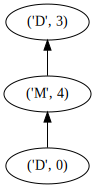

In [14]:
clf.show_q_diagram()

In [15]:
clf.q_model.feature_importances_

{0: 1.0}

In [16]:
# Multi-target
q_code=np.zeros(clf.m_codes[0].shape[0], dtype=int)
q_code[-2:] = 1
print("Query code is: {}".format(q_code))

y_pred = clf.predict(test, q_code=q_code)
y_pred[:10]

Query code is: [0 0 1 1]
('D', 2)
('M', 0)
('M', 3)
('D', 3)
('M', 4)


array([[ 0.15161875,  0.        ],
       [-0.07064853,  0.        ],
       [ 0.15161875,  0.        ],
       [ 0.21392281,  1.        ],
       [ 0.03979332,  0.        ],
       [-0.20459606,  0.        ],
       [ 0.21392281,  1.        ],
       [-0.20459606,  1.        ],
       [-0.31503791,  1.        ],
       [-0.17568144,  1.        ]])

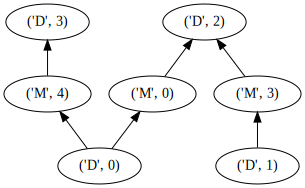

In [17]:
clf.show_q_diagram()

In [18]:
clf.q_model.feature_importances_

{0: 0.75, 1: 0.25}

In [19]:
# Missing attributes
q_code=np.zeros(clf.m_codes[0].shape[0], dtype=int)
q_code[-1:] = 1
q_code[:2] = -1
print("Query code is: {}".format(q_code))

y_pred = clf.predict(test, q_code=q_code)
y_pred[:10]

Query code is: [-1 -1  0  1]
('D', 3)
('M', 4)
('D', 0)
('M', 1)


array([0., 0., 0., 0., 0., 0., 0., 1., 1., 0.])

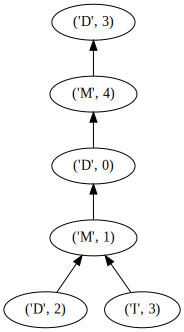

In [21]:
clf.show_q_diagram()

In [22]:
clf.q_model.feature_importances_

{2: 0.297670148394614, 3: 0.0}